# General Configuration
### Imports all the necessary libraries

In [ ]:
%pip install --upgrade pip
%pip install quantstats
%pip install matplotlib

In [3]:
import os
import pandas as pd
from datetime import datetime
from operator import itemgetter
import matplotlib.pyplot as plt
import quantstats as qs

## Data management

In [4]:
def load_csv_files(num_weeks, data_folder='../data/ethereum-tokens', inclusion = 1):
    
    # List all files in the directory
    files = os.listdir(data_folder)
    
    # Filter out files that are not CSV
    files = [f for f in files if f.endswith('.csv')]
    
    # Extract dates from file names and pair them with file names
    files_with_dates = []
    for file in files:
        date_str = file.replace('.csv', '')
        date = datetime.strptime(date_str, '%Y-%m-%d')
        files_with_dates.append((file, date))
    
    # Sort files by date
    sorted_files_with_dates = sorted(files_with_dates, key=itemgetter(1))
    
    # Select every Nth file based on the num_weeks
    selected_files = [file for i, (file, date) in enumerate(sorted_files_with_dates) if i % num_weeks == 0]
    
    # Load selected files
    dfs = []
    token_presence_count = {}
    
    for file in selected_files:
        df = pd.read_csv(os.path.join(data_folder, file), index_col='Rank')
        
        # Count the presence of each token in the top tokens list
        tokens_to_remove = []

        for token_id in df['id']:
            token_presence_count[token_id] = token_presence_count.get(token_id, 0) + 1

        if len(dfs) > 2*inclusion:  # start checking from the n+1th week onwards
            for token_id in df['id']:
                if token_id in token_presence_count:
                    if token_presence_count[token_id] < inclusion:
                        tokens_to_remove.append(token_id)
                else:
                    tokens_to_remove.append(token_id)

        df = df[~df['id'].isin(tokens_to_remove)]
        
        dfs.append(df)

    return dfs

## Helper functions for calculate_index

In [5]:
def compute_divisor(snapshot, target_price=None):
    total_market_cap_0 = snapshot['Market cap'].sum()

    return total_market_cap_0 / target_price

def compute_current_value(snapshot, divisor):
    if divisor == 0:
        return None
    daily_value = snapshot['Market cap'].sum()
    index_value_t = daily_value / divisor
    return index_value_t

In [6]:
def compute_index_history(constituent_number, weeks_interval, initial_index_value = 100, swap_fees = 0, inc = 1):

    source_dfs = load_csv_files(weeks_interval, inclusion = inc)

    folder = f"../data/{weeks_interval}w-ethereum-tokens"

    files = os.listdir(folder)
    
    # Filter out files that are not CSV
    files = [f for f in files if f.endswith('.csv')]
    files = sorted(files)

    shifted_dfs = []

    for file in files:
        df = pd.read_csv(os.path.join(folder, file), index_col='Rank')
        shifted_dfs.append(df)
    
    index_values = [initial_index_value]

    index_value = initial_index_value

    # print(source_dfs)
    # print(shifted_dfs)
    
    # Loop over all the data for backtesting
    for i in range(len(source_dfs)):
        source_df = source_dfs[i][:constituent_number]

        selected_tokens = set(source_df['id'])  # Get the tokens chosen in the source_df

        divisor = compute_divisor(source_df, index_value)
        # print(len(source_df))

        # Get data for all weeks between the rebalancing periods.
        for j in range(weeks_interval):
            if i*weeks_interval+j >= len(shifted_dfs):
                break

            shifted_df = shifted_dfs[i*weeks_interval+j][:constituent_number]

            # Filter the shifted_df to consider only the selected tokens
            shifted_df = shifted_df[shifted_df['id'].isin(selected_tokens)][:constituent_number]
            
            index_value = compute_current_value(shifted_df, divisor)
            if(j == weeks_interval-1):
                index_value -= swap_fees * constituent_number
            index_values.append(index_value)
            
    return index_values[:-1]


### Main calculate_index function

In [7]:
backtest = []

weeks = [1, 2, 4, 8, 12, 24]
constituents = [5, 10, 20, 30]
# constituents = [100]
# weeks = [2]

initial_value = 100
swap_fees = 0
inclusion_weeks = 1

for week in weeks:
    for constituent in constituents:
        backtest.append((compute_index_history(constituent, week, initial_value, swap_fees, inclusion_weeks), week, constituent))

backtest.sort(key=lambda x: x[0][-1], reverse=True)

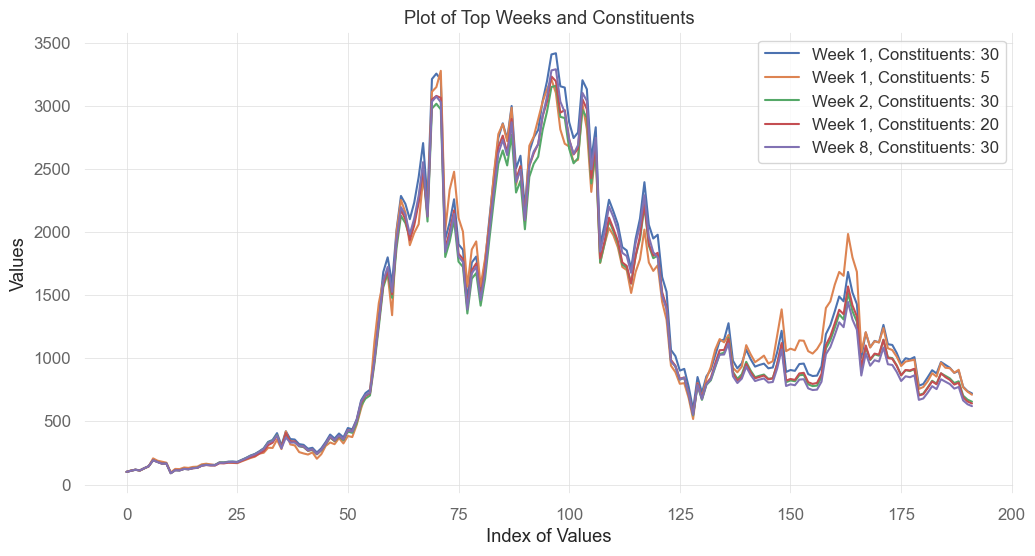

In [10]:
top_backtests = backtest[:5]

plt.figure(figsize=(12, 6))

for values, week, constituents in top_backtests:
    # assuming the values are the y-values and you want to plot them over the week
    plt.plot(values, label=f"Week {week}, Constituents: {constituents}")

plt.xlabel('Index of Values')
plt.ylabel('Values')
plt.title("Plot of Top Weeks and Constituents")
# plt.yscale('log')
plt.legend()
plt.show()

## Performance analysis

In [28]:
values, week, constituent = top_backtests[0]

prices_series = pd.Series(values, name=f'Weeks: {week}, Constituents: {constituent}')

returns = prices_series.pct_change().dropna()

dates = pd.date_range(start='1/12/2020', periods=len(prices_series)-1, freq='W')

returns.index = dates

# risk_free = pd.read_csv("../data/risk-free.csv")
# risk_free_rate = risk_free["risk-free"].mean()/100
risk_free_rate = 0.5

                           Strategy
-------------------------  ----------
Start Period               2020-01-12
End Period                 2023-09-03
Risk-Free Rate             50.0%
Time in Market             100.0%

Cumulative Return          230.34%
CAGR﹪                     25.41%

Sharpe                     1.65
Prob. Sharpe Ratio         0.0%
Smart Sharpe               1.53
Sortino                    2.49
Smart Sortino              2.3
Sortino/√2                 1.76
Smart Sortino/√2           1.63
Omega                      1.33

Max Drawdown               -83.49%
Longest DD Days            834
Volatility (ann.)          215.14%
Calmar                     0.3
Skew                       -0.14
Kurtosis                   1.47

Expected Daily %           0.63%
Expected Monthly %         2.69%
Expected Yearly %          34.82%
Kelly Criterion            15.15%
Risk of Ruin               0.0%
Daily Value-at-Risk        -20.72%
Expected Shortfall (cVaR)  -20.72%

Max Consecutive Wins  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-05-23,2022-06-19,2023-09-03,834,-83.486460,-82.274909
2,2020-02-23,2020-03-15,2020-07-12,141,-53.836778,-41.965122
3,2020-09-06,2020-11-01,2020-12-27,113,-38.637284,-33.864784
4,2021-04-25,2021-04-25,2021-04-25,1,-16.702486,NaN
5,2021-02-28,2021-02-28,2021-02-28,1,-12.057878,NaN


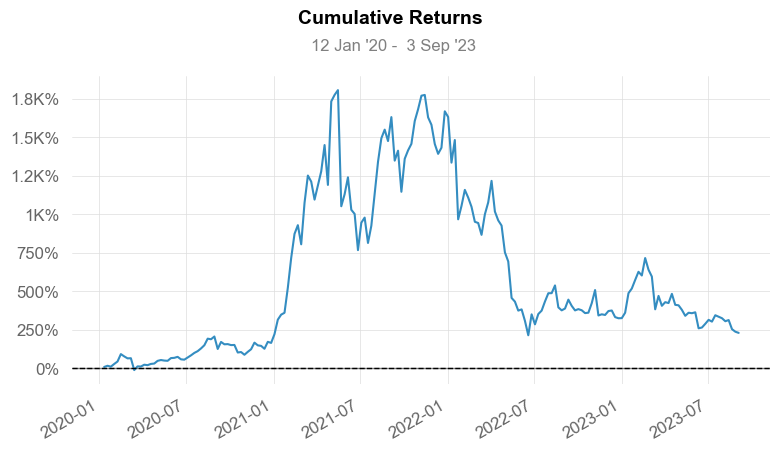

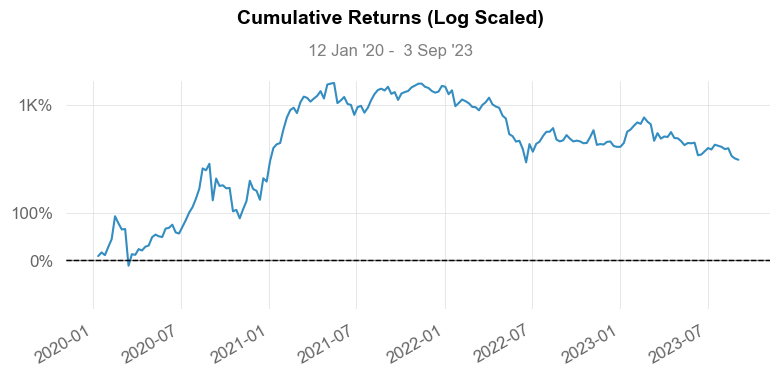

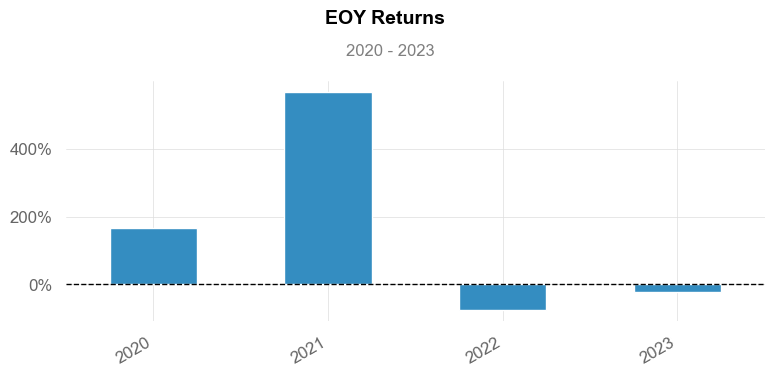

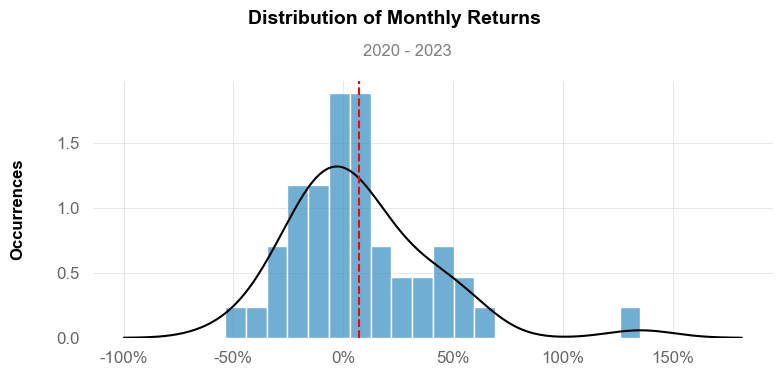

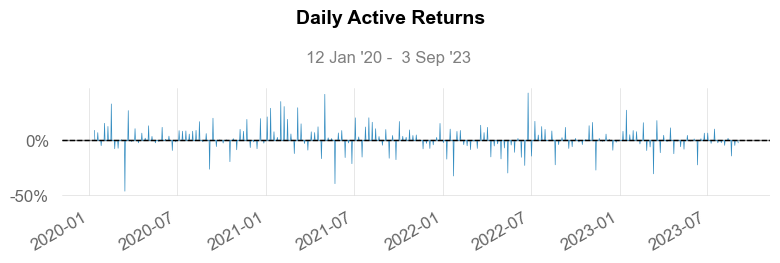

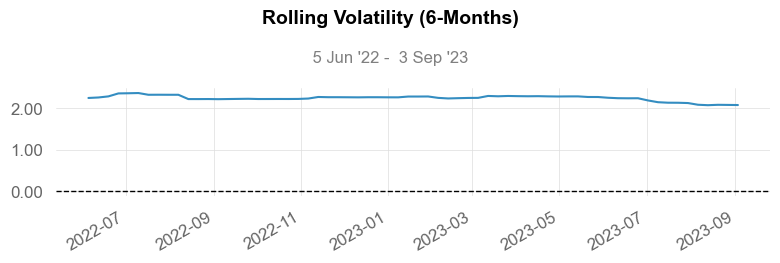

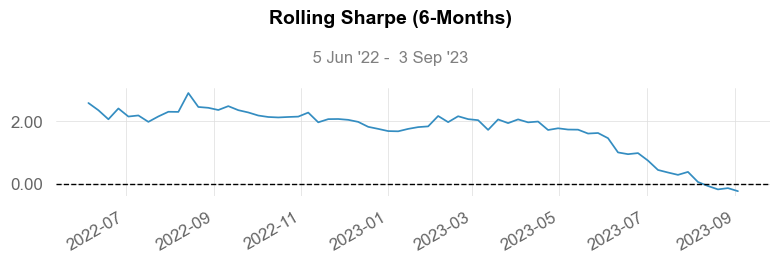

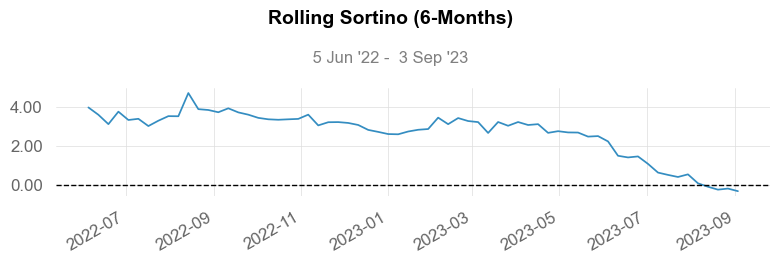

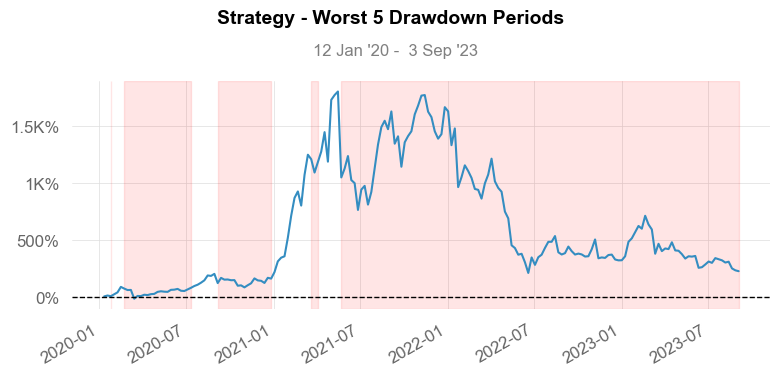

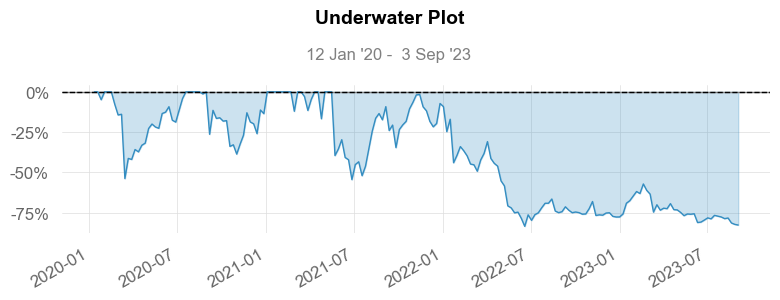

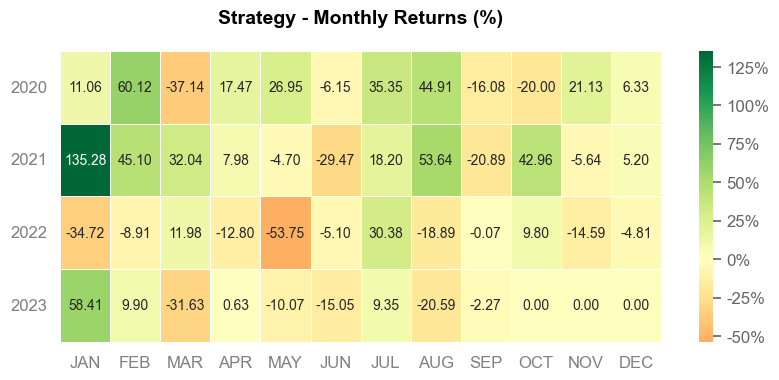

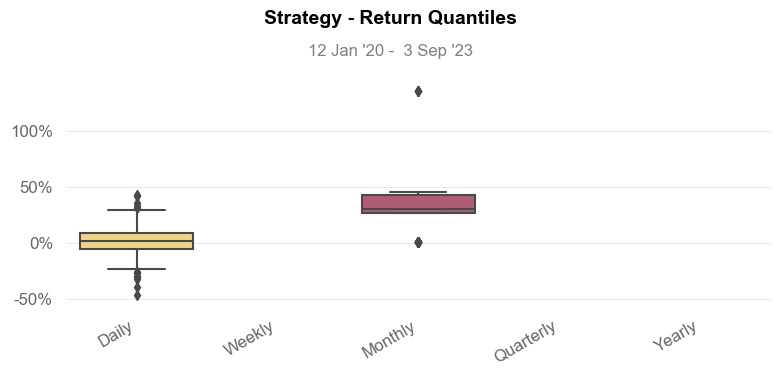

In [29]:
qs.reports.full(returns, rf=risk_free_rate)